In [3]:
import os
import sys

from pathlib import Path


# si aggiunge al path la cartella utils per avere visibilità del module
module_path = Path(os.getcwd()).parent.parent
module_path = os.path.join(module_path, "project-detective")

sys.path.append(module_path)

In [2]:
import timm
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import utils.mining as mining
import utils.datasets as build

from torch import nn
from tqdm import tqdm
from skimage import io
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from pytorch_metric_learning import miners, losses
from sklearn.model_selection import train_test_split

In [4]:
# serve per ricaricare il codice modificato
%load_ext autoreload
%autoreload 2

In [5]:
# configurazione
batch_size=32
lr=0.001
epochs=30
device="cuda"

# per far funzionare il modello su immagini rgb o in scala di grigi (per usare fourier)
mode="rgb"

# margin per semi-hard mining con modello pre-allenato
margin=0.2

In [6]:
# directory da dove vengono prelevate le immagini
path = Path(os.getcwd()).parent.parent

fake_data_dir = os.path.join(path, "artifact", "taming_transformer")
real_data_dir = os.path.join(path, "artifact", "coco")

In [7]:
# carica le immagini nel dataset
class ApnDataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    if mode == "rgb":
      # le immagini Anchor sono memorizzate in due dataset diversi
      if str(row.Anchor).startswith("coco"):
        a_img = io.imread(os.path.join(real_data_dir, row.Anchor))
        p_img = io.imread(os.path.join(real_data_dir, row.Positive))
        n_img = io.imread(os.path.join(fake_data_dir, row.Negative))

        a_label = 0
        p_label = 0
        n_label = 1

      else:
        a_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
        p_img = io.imread(os.path.join(fake_data_dir, row.Positive))
        n_img = io.imread(os.path.join(real_data_dir, row.Negative))

        a_label = 1
        p_label = 1
        n_label = 0

      # normalizzazione per immagini in rgb 
      a_img = torch.from_numpy(a_img).permute(2, 0, 1) / 255.0
      p_img = torch.from_numpy(p_img).permute(2, 0, 1) / 255.0
      n_img = torch.from_numpy(n_img).permute(2, 0, 1) / 255.0

      a_label = torch.tensor(a_label)
      p_label = torch.tensor(p_label)
      n_label = torch.tensor(n_label)

    if mode == "grey_scale":
      a_img = np.expand_dims(a_img, 0)
      p_img = np.expand_dims(p_img, 0)
      n_img = np.expand_dims(n_img, 0)
      
      a_img = torch.from_numpy(a_img) / 255.0
      p_img = torch.from_numpy(p_img) / 255.0
      n_img = torch.from_numpy(n_img) / 255.0

    # A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    # P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    # N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return a_img, p_img, n_img, a_label, p_label, n_label

In [8]:
# classe per caricare il modello di rete neurale direttamente dalle repository online
class ApnModel(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size=512):
    super(ApnModel, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [9]:
# classe del modello che genera gli embedding per applicare il semi-hard mining
class EmbModel(nn.Module):

    # size del vettore di embedding
    def __init__(self, emb_size = 512):
        super(EmbModel, self).__init__()

        # gli embedding vengono creati con un modello preallenato (risultato più efficace in test precedenti)
        self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings

In [10]:
# funzione per creare embeddings che sarranno sottoposti a semi-hard mining
def create_embeddings(model, dataloader, device): 
    # off dropout
    model.eval()

    list_df = []

    with torch.no_grad():
        for a, p, n, al, pl, nl in tqdm(dataloader, desc="creating embeddings..."):
            a, p, n = a.to(device), p.to(device), n.to(device)

            temp_df_embs = pd.DataFrame(columns=["Anchor_embs", "Positive_embs", "Negative_embs"])

            a_embs = model(a)
            p_embs = model(p)
            n_embs = model(n)
            
            # la batch size può variare, perciò ci si basa sulla lunghezza del tensore
            batch_size = len(a_embs)
            
            # ad ogni batch corrisponde un dataframe
            for i in range(batch_size): 
                # si serializzano gli array np in stringhe in modo da memorizzarli nelle celle del datagrame
                a, p, n = a_embs[i].cpu().numpy(), p_embs[i].cpu().numpy(), n_embs[i].cpu().numpy()
                a, p, n = np.array2string(a, separator=','), np.array2string(p, separator=','), np.array2string(n, separator=',')
                
                temp_df_embs.loc[i] = [
                    a, 
                    p, 
                    n
                ]
            
            list_df.append(temp_df_embs)

    # concatenazione di tutti i dataframe
    df_embs = pd.concat(list_df)

    return df_embs

In [11]:
emb_model = EmbModel()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    emb_model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

emb_model.to(device)

EmbModel(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act):

In [ ]:
path = Path(os.getcwd()).parent.parent
fake_dataset_path = os.path.join(path, "artifact", "taming_transformer", "metadata.csv")
real_dataset_path = os.path.join(path, "artifact", "coco", "metadata.csv")

# creo il dataset di triplet iniziale (i triplet sono scelti casualmente)
df_out_path = os.path.join("..", "datasets", "out.csv")
build.train(fake_dataset_path, real_dataset_path, df_out_path, 50000)

In [13]:
df_out_path = os.path.join("..", "datasets", "out.csv")
df_out = pd.read_csv(df_out_path)

apn_dataset = ApnDataset(df_out)
dataloader = DataLoader(apn_dataset, batch_size=batch_size)

In [14]:
emb_csv_path = os.path.join("..", "notebooks", "embeddings.csv")

# si controlla che siano stati già creati gli embeddings
if not Path(emb_csv_path).is_file():
    df_emb = create_embeddings(emb_model, dataloader, device)
    df_emb.to_csv(emb_csv_path, index=False)

df_emb = pd.read_csv(emb_csv_path)

In [16]:
# si concatenano i dataframe delle immagini e degli embeddings sulle colonne per poter filtrare le righe in logica di semi-hard mining
df = pd.concat([df_out, df_emb], axis=1)

# offline semi-hard mining dei triplets
df = mining.offline_semi_hard_mining(df, margin)
df = df.drop(["Anchor_embs", "Positive_embs", "Negative_embs"], axis=1)

print(f"dataset size after semi-hard mining: {len(df)}")

dataset size after semi-hard mining: 6770


In [23]:
# funzione di train
# def train_fn(model, dataloader, optimizer, criterion, miner):
def train_fn(model, dataloader, optimizer, criterion):
  # on dropout 
  model.train()
  
  total_loss = 0.0

  for a, p, n, al, pl, nl in tqdm(dataloader, desc="model training..."):
    a, p, n = a.to(device), p.to(device), n.to(device)
    al, pl, nl = al.to(device), pl.to(device), nl.to(device)

    optimizer.zero_grad()

    # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
    a_embs = model(a)
    p_embs = model(p)
    n_embs = model(n)

    # per usare l'ohm si devono concatenare tutti i tipi di immagine, i triplet verranno creati nella funzione di loss
    # embeddings = torch.cat((a_embs, p_embs, n_embs), axis=0)
    # labels = torch.cat((al, pl, nl), axis=0)

    # online hard mining prima del calcolo della loss
    # miner_output = miner(embeddings, labels)
    # loss = criterion(embeddings, labels, miner_output)
    size = len(a_embs)
    a_embs, p_embs, n_embs = mining.online_hard_mining(a_embs, p_embs, n_embs, size, device)
    loss = criterion(a_embs, p_embs, n_embs)
    loss.backward()
    
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [24]:
# funzione di evaluation
def eval_fn(model, dataloader, criterion):
  # off dropout
  model.eval() 
  
  total_loss = 0.0

  with torch.no_grad():
    for a, p, n, al, pl, nl in tqdm(dataloader, desc="model validating..."):
      a, p, n = a.to(device), p.to(device), n.to(device)
      al, pl, nl = al.to(device), pl.to(device), nl.to(device)

      a_embs = model(a)
      p_embs = model(p)
      n_embs = model(n)

      # embeddings = torch.cat((a_embs, p_embs, n_embs), axis=0)
      # labels = torch.cat((al, pl, nl), axis=0)

      # loss = criterion(embeddings, labels)
      loss = criterion(a_embs, p_embs, n_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [25]:
model = ApnModel()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(device)

ApnModel(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act):

In [26]:
# split del nuovo dataframe
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

trainset = ApnDataset(train_df)
validset = ApnDataset(valid_df)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)

In [27]:
# triplet loss, miner (per online hard mining) e adam
criterion = nn.TripletMarginLoss()
# criterion = losses.TripletMarginLoss(triplets_per_anchor=1)
# miner = miners.TripletMarginMiner(margin=margin, type_of_triplets="hard")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [28]:
# training
best_valid_loss = np.Inf

training_epoch_loss = []
validation_epoch_loss = []

for i in range(epochs):
  # train_loss = train_fn(model, trainloader, optimizer, criterion, miner)
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  training_epoch_loss.append(train_loss)
  validation_epoch_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("successful weights saving...")

  print(f"epochs: {i+1}, train_loss: {train_loss}, valid_loss: {valid_loss}")

model validating...:  98%|█████████▊| 42/43 [02:32<00:03,  3.54s/it]c:\Users\raffa\anaconda3\envs\fvab\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
model validating...: 100%|██████████| 43/43 [02:33<00:00,  3.57s/it]


successful weights saving...
epochs: 1, train_loss: 1.0, valid_loss: 2.319122468316278


model validating...: 100%|██████████| 43/43 [02:52<00:00,  4.01s/it]


epochs: 2, train_loss: 1.0, valid_loss: 2.616478079973265


model validating...: 100%|██████████| 43/43 [01:48<00:00,  2.53s/it]


epochs: 3, train_loss: 1.0, valid_loss: 2.5376359792642815


model validating...: 100%|██████████| 43/43 [01:35<00:00,  2.22s/it]


epochs: 4, train_loss: 1.0, valid_loss: 2.8666262280109316


model validating...: 100%|██████████| 43/43 [00:55<00:00,  1.30s/it]


epochs: 5, train_loss: 1.0, valid_loss: 2.777947464654612


model validating...: 100%|██████████| 43/43 [00:21<00:00,  1.96it/s]


epochs: 6, train_loss: 1.0, valid_loss: 2.9774723829225054


model validating...: 100%|██████████| 43/43 [00:24<00:00,  1.77it/s]


epochs: 7, train_loss: 1.0, valid_loss: 2.861196170019549


model validating...: 100%|██████████| 43/43 [00:26<00:00,  1.63it/s]


successful weights saving...
epochs: 8, train_loss: 1.0, valid_loss: 2.1997130388437314


model validating...: 100%|██████████| 43/43 [00:24<00:00,  1.72it/s]


epochs: 9, train_loss: 1.0, valid_loss: 3.2001021046971165


model validating...: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]


epochs: 10, train_loss: 1.0, valid_loss: 2.935169125712195


model validating...: 100%|██████████| 43/43 [00:25<00:00,  1.68it/s]


epochs: 11, train_loss: 1.0, valid_loss: 3.0949352189551953


model validating...: 100%|██████████| 43/43 [00:28<00:00,  1.51it/s]


epochs: 12, train_loss: 1.0, valid_loss: 2.919119868167611


model validating...: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]


epochs: 13, train_loss: 1.0, valid_loss: 3.38243623944216


model validating...: 100%|██████████| 43/43 [00:31<00:00,  1.37it/s]


epochs: 14, train_loss: 1.0, valid_loss: 2.8942590147949927


model validating...: 100%|██████████| 43/43 [00:26<00:00,  1.59it/s]


epochs: 15, train_loss: 1.0, valid_loss: 2.500163729800734


model validating...: 100%|██████████| 43/43 [00:27<00:00,  1.54it/s]


epochs: 16, train_loss: 1.0, valid_loss: 3.1967819249907206


model validating...: 100%|██████████| 43/43 [00:34<00:00,  1.23it/s]


epochs: 17, train_loss: 1.0, valid_loss: 2.7270595999651177


model validating...: 100%|██████████| 43/43 [00:23<00:00,  1.84it/s]


epochs: 18, train_loss: 1.0, valid_loss: 2.9790873444357584


model validating...: 100%|██████████| 43/43 [00:21<00:00,  1.97it/s]


epochs: 19, train_loss: 1.0, valid_loss: 2.660951331604359


model validating...: 100%|██████████| 43/43 [00:21<00:00,  2.02it/s]


epochs: 20, train_loss: 1.0, valid_loss: 3.2548431158065796


model validating...: 100%|██████████| 43/43 [00:26<00:00,  1.61it/s]


epochs: 21, train_loss: 1.0, valid_loss: 2.862832777721937


model validating...: 100%|██████████| 43/43 [00:30<00:00,  1.41it/s]


epochs: 22, train_loss: 1.0, valid_loss: 2.854075846283935


model validating...: 100%|██████████| 43/43 [00:23<00:00,  1.84it/s]


epochs: 23, train_loss: 1.0, valid_loss: 2.89062208353087


model validating...: 100%|██████████| 43/43 [00:23<00:00,  1.84it/s]


epochs: 24, train_loss: 1.0, valid_loss: 2.6332969623942706


model validating...: 100%|██████████| 43/43 [00:56<00:00,  1.32s/it]


epochs: 25, train_loss: 1.0, valid_loss: 3.734464864398158


model validating...: 100%|██████████| 43/43 [00:23<00:00,  1.85it/s]


epochs: 26, train_loss: 1.0, valid_loss: 3.04776070284289


model validating...: 100%|██████████| 43/43 [00:23<00:00,  1.81it/s]


epochs: 27, train_loss: 1.0, valid_loss: 2.7872743592705835


model validating...: 100%|██████████| 43/43 [00:33<00:00,  1.29it/s]


epochs: 28, train_loss: 1.0, valid_loss: 2.933988609979319


model validating...: 100%|██████████| 43/43 [00:23<00:00,  1.87it/s]


epochs: 29, train_loss: 1.0, valid_loss: 2.327922072521476


model validating...: 100%|██████████| 43/43 [00:23<00:00,  1.81it/s]

epochs: 30, train_loss: 1.0, valid_loss: 3.009561438893163


<function matplotlib.pyplot.show(close=None, block=None)>

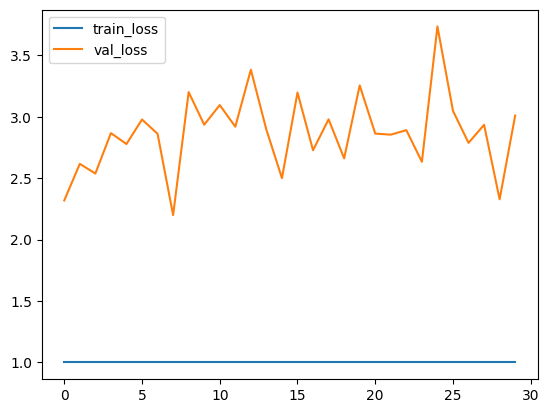

In [29]:
# plot della training e validation loss
plt.plot(training_epoch_loss, label="train_loss")
plt.plot(validation_epoch_loss, label="val_loss")
plt.legend()

plt.show

In [30]:
path = Path(os.getcwd()).parent.parent
fake_dataset_path = os.path.join(path, "artifact", "taming_transformer", "metadata.csv")
real_dataset_path = os.path.join(path, "artifact", "coco", "metadata.csv")

# creo il dataset di test
testList_df_path = os.path.join("..", "datasets", "testList.csv")
build.test(fake_dataset_path, real_dataset_path, testList_df_path, df)

building (fake column) test dataframe...: 100%|██████████| 1354/1354 [00:00<00:00, 1473.80it/s]


In [31]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr, desc="creating encodings..."):

      if mode == "rgb":
        # serve per trovare correttamente l'immagine
        if str(i).startswith("coco"):
          dir_folder = real_data_dir
          a = io.imread(os.path.join(dir_folder, i))

        else: 
          dir_folder = fake_data_dir
          a = io.imread(os.path.join(dir_folder, i))

        a = torch.from_numpy(a).permute(2, 0, 1) / 255.0
      
      if mode == "grey_scale":
        a = io.imread(os.path.join(dir_folder,i))
        a = np.expand_dims(a, 0)
        a = torch.from_numpy(a.astype(np.int32)) / 255.0
        
      a = a.to(device)
      a_enc = model(a.unsqueeze(0))
      encodings.append(a_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [32]:
# per ricaricare il modello una volta allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati per non rifarlo ad ogni allenamento
df_enc = get_encoding_csv(model, df["Anchor"], real_data_dir)
df_enc.to_csv("database.csv", index=False)

creating encodings...: 100%|██████████| 6770/6770 [02:35<00:00, 43.61it/s]


In [33]:
df_enc = pd.read_csv('database.csv')
df_enc.head()

C:\Users\raffa\AppData\Local\Temp\ipykernel_10232\2812054046.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_enc = pd.read_csv('database.csv')


,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,coco/coco2017/test2017/img021492.jpg,0.210612,0.172811,-0.032277,-0.015216,-0.018282,0.005794,-0.103214,0.016559,0.050845,...,0.058325,0.111922,0.082920,0.034675,-0.006594,-0.082917,-0.135906,0.052635,-0.087498,-0.030560
1,coco/coco2017/train2017/img086769.jpg,0.108900,-0.020698,0.043000,-0.013082,0.147749,0.128421,0.056875,0.023271,-0.016304,...,0.023715,0.100520,0.096159,0.008015,-0.022342,0.048572,0.044502,-0.023100,-0.025953,-0.067082
2,coco/coco2017/train2017/img131066.jpg,0.094263,0.047014,0.010586,0.005190,0.079097,0.110496,0.008993,0.039684,0.014335,...,0.009584,0.093602,0.081865,0.020606,-0.024171,0.023134,0.003913,0.009926,-0.064054,-0.082294
3,coco/coco2017/test2017/img031702.jpg,0.100440,-0.009643,0.018857,-0.018780,0.075334,0.081169,0.008256,-0.005822,0.013397,...,0.054586,0.135010,0.033176,0.044009,0.012364,0.039068,-0.043427,0.015620,-0.060722,-0.106457
4,coco/coco2017/test2017/img023357.jpg,0.230011,0.782740,-0.013900,0.454633,-0.078151,-0.146744,-0.193938,0.072557,0.253341,...,0.068413,0.040207,0.023596,-0.067577,-0.047799,-0.024769,-0.430299,0.079165,-0.179303,-0.012277


In [34]:
# approssimazione della distanza, senza la radice quadrata, per fare i primi allenamenti velocemente
def euclidean_dist(img_enc, anc_enc_arr):
    # dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T)
    # dist = np.sqrt(dist)
    return dist

In [35]:
path = os.path.join(Path(os.getcwd()).parent, "datasets", "testList.csv")
df = pd.read_csv(path)

print(df["real"])
print(df.size)
df.head()

0       coco/coco2017/train2017/img132965.jpg
1       coco/coco2017/train2017/img050158.jpg
2       coco/coco2017/train2017/img048933.jpg
3       coco/coco2017/train2017/img122642.jpg
4       coco/coco2017/train2017/img045822.jpg
                        ...                  
1349     coco/coco2017/test2017/img013078.jpg
1350    coco/coco2017/train2017/img142556.jpg
1351    coco/coco2017/train2017/img078365.jpg
1352    coco/coco2017/train2017/img076725.jpg
1353    coco/coco2017/train2017/img140844.jpg
Name: real, Length: 1354, dtype: object
2708


,real,fake
0,coco/coco2017/train2017/img132965.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/130/img00183...
1,coco/coco2017/train2017/img050158.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/174/img00421...
2,coco/coco2017/train2017/img048933.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img036265.jpg
3,coco/coco2017/train2017/img122642.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/126/img00158...
4,coco/coco2017/train2017/img045822.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img029006.jpg


In [36]:
def get_image_embeddings(img, model):
    if mode == "rgb":
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
      
    if mode == "grey_scale":
        img = np.expand_dims(img, 0)
        img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(device)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [37]:
def search_in_database(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [38]:
# DataTestReal = 'C:/Users/polsi/Desktop/Lavori/DeepFake/Datasets/Artifact/cycle_gan/st/test/'
path = Path(os.getcwd()).parent.parent
real_dataset_dir = os.path.join(path, "artifact", "coco")
fake_dataset_dir = os.path.join(path, "artifact", "taming_transformer")

y_true = []
y_pred = []

temp_df = df
temp_df.head()
temp_df.shape

(1354, 2)

In [39]:
# testo i fake
current_test = "fake"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(temp_df.iterrows(), desc="testing on fake images..."):
    path = os.path.join(fake_dataset_dir, row[current_test])
    img_name = path

    img = io.imread(img_name)

    img_enc = get_image_embeddings(img, model)

    closest_label = search_in_database(img_enc, database)

    if mode == "rgb":
        if str(closest_label).startswith("coco"):
            y_pred.append("real")
        else:
            y_pred.append("fake")

    if mode == "grey_scale": 
        if "real" in closest_label:
            y_pred.append("real")
        else:
            y_pred.append("fake")

testing on fake images...: 1354it [05:19,  4.24it/s]


In [40]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
1354
['fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 

In [41]:
# testo i real
current_test = "real"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(temp_df.iterrows(), desc="testing on real images..."):
    path = os.path.join(real_dataset_dir, row[current_test])
    img_name = path

    img = io.imread(img_name)

    img_enc = get_image_embeddings(img, model)

    closest_label = search_in_database(img_enc, database)
    
    if mode == "rgb":
        if str(closest_label).startswith("coco"):
            y_pred.append("real")
        else:
            y_pred.append("fake")

    if mode == "grey_scale":
        if "real" in closest_label:
            y_pred.append("real")
        else:
            y_pred.append("fake")


testing on real images...: 1354it [05:19,  4.24it/s]


In [42]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
2708
['fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 

In [44]:
# creo i vettori di ground truth
int(len(df) / 100 * 20)

y_true = np.array(["fake"] * len(valid_df))
print(y_true.shape)

temp = np.array(["real"] * len(valid_df))
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

(1354,)
(1354,)
(2708,)
[[ 219 1135]
 [ 185 1169]]


In [45]:
tn, fp, fn, tp = cm.ravel()

# metriche
accuracy = round((tp + tn) / (tp + tn + fp + fn), 4) * 100
precision = round((tp) / (tp + fp), 4) * 100
recall = round((tp) / (tp + fn), 4) * 100
specificity = round((tn) / (tn + fp) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

{'Accuracy': 51.25999999999999, 'Precision': 50.739999999999995, 'Recall': 86.33999999999999, 'Specificity': 16.1743, 'F1 Score': 63.9173}


In [46]:
# si salvano i risultati in un file .csv
df_results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
df_results.loc[0] = [accuracy, precision, recall, specificity, f1_score]

# si differenziano i risultati in base al tipo di immagini e dataset usati
dataset = fake_data_dir.split("\\")[-1]
path = os.path.join("..", "results", "rgb_mining", "siamese_" + mode + "_" + "pretrained_semi_hard_online_hard_" + dataset + "_results.csv")

df_results.to_csv(path, index=False)